# WIND TURBINE DATA ANALYSIS

## PART 0: IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## PART I: IMPORT DATA

In [2]:
cwd = os.getcwd()
data_wd = cwd + '/data/la-haute-borne-data-2013-2016.csv'
data = pd.read_csv(data_wd,sep=';')

In [3]:
data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80711,2014-09-25T09:40:00+02:00,-0.89,-0.99,0.00,0.28,18.150000,18.0,19.000000,0.27,...,NaN,NaN,289.97000,NaN,NaN,NaN,300.07999,NaN,NaN,NaN
1,R80711,2014-07-29T01:00:00+02:00,-0.99,-0.99,-0.99,0.00,23.010000,23.0,23.959999,0.07,...,NaN,NaN,249.77000,NaN,NaN,NaN,244.11000,NaN,NaN,NaN
2,R80711,2014-05-26T22:00:00+02:00,-0.99,-0.99,-0.99,0.00,22.000000,22.0,22.000000,0.00,...,NaN,NaN,239.24001,NaN,NaN,NaN,233.13000,NaN,NaN,NaN
3,R80711,2014-05-27T02:50:00+02:00,-0.99,-0.99,-0.99,0.00,20.389999,20.0,21.000000,0.41,...,NaN,NaN,257.63000,NaN,NaN,NaN,269.35001,NaN,NaN,NaN
4,R80711,2014-06-19T01:20:00+02:00,-0.99,-0.99,-0.99,0.00,23.010000,23.0,23.730000,0.05,...,NaN,NaN,13.18000,NaN,NaN,NaN,7.04000,NaN,NaN,NaN


## PART II: DATA CLEANING AND PREPROCESSING

### CALENDAR FEATURES CREATION

In [4]:
data['Date_time'] = pd.to_datetime(data['Date_time'])
data.sort_values(by=['Date_time'], inplace=True, ascending=True)

data['Year'] = data['Date_time'].dt.year
data['Month'] = data['Date_time'].dt.month

In [5]:
data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std,Year,Month
209184,R80711,2012-12-31 23:00:00,-1.00,-1.0,-1.0,0.0,12.76,12.0,13.0,0.36,...,180.25000,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
13935,R80711,2012-12-31 23:10:00,-1.00,-1.0,-1.0,0.0,12.71,12.0,13.0,0.38,...,183.28999,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
204824,R80711,2012-12-31 23:20:00,-1.00,-1.0,-1.0,0.0,12.81,12.0,13.0,0.31,...,185.08000,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
13931,R80711,2012-12-31 23:30:00,-1.00,-1.0,-1.0,0.0,12.70,12.0,13.0,0.38,...,190.33000,NaN,NaN,NaN,188.41000,NaN,NaN,NaN,2012,12
203,R80711,2012-12-31 23:40:00,-0.98,-1.0,-0.5,0.1,12.40,12.0,13.0,0.41,...,188.07001,NaN,NaN,NaN,192.89999,NaN,NaN,NaN,2012,12


### MISSING VALUES TREATMENT
Plot of missing value count for each column of the dataframe. Columns with a number of missing values above a critical limit will be dropped. Columns with a reasonable number of NaN will be kept. Every row with one or more missing value will be dropped. For this analysis, it is not strictly mandatory to keep all the available features, yet for more sophisticated analysis there is a subtle trade-off:
* keep a large number of sample, dropping most of the features with the largest number of NaN
* keep as many features as you can, so that you don't lose pieces of information. In this case, you accept to lose more data samples, since more rows will be affected by NaN.

The replacement of NaN values with other values, such as average/median or other statistical approaches, is not recommended in this case. If you are going to build a physical models, or even a machine learning model with the aim of describing a physical sistem like a WTG, it is better to avoid heavy manipulation procedures. The identification of patterns of features can be negatively affected in this case. Better to lose weak data sample than add in your analysis unphysical data samples.

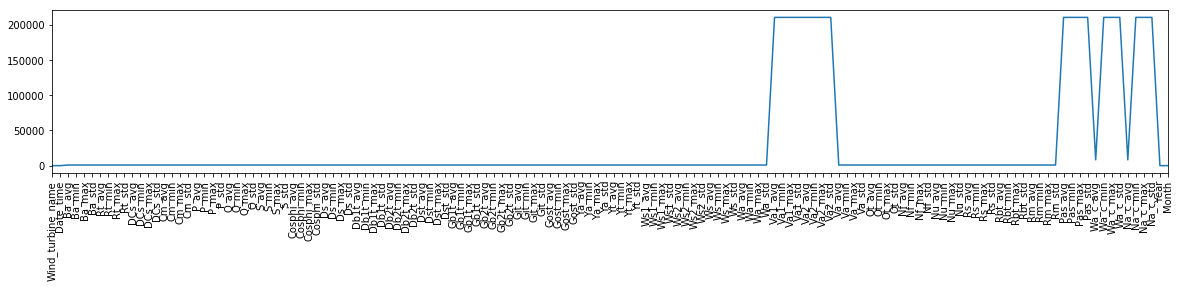

In [6]:
plt.figure(figsize=(20,3))
plt.plot(data.isnull().sum(axis = 0))
plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()

In [7]:
print('List of columns deleted because of NaN count exceeds maximum threshold')
print(list(data.loc[:,data.isnull().sum(axis = 0) > 10000].columns))

List of columns deleted because of NaN count exceeds maximum threshold
['Va1_avg', 'Va1_min', 'Va1_max', 'Va1_std', 'Va2_avg', 'Va2_min', 'Va2_max', 'Va2_std', 'Pas_avg', 'Pas_min', 'Pas_max', 'Pas_std', 'Wa_c_min', 'Wa_c_max', 'Wa_c_std', 'Na_c_min', 'Na_c_max', 'Na_c_std']


In [8]:
df = data.loc[:,data.isnull().sum(axis = 0) < 10000]

In [9]:
df.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg,Year,Month
209184,R80711,2012-12-31 23:00:00,-1.00,-1.0,-1.0,0.0,12.76,12.0,13.0,0.36,...,28.799999,0.03,5690.2798,4037.4900,7382.7202,612.64001,180.25000,176.44000,2012,12
13935,R80711,2012-12-31 23:10:00,-1.00,-1.0,-1.0,0.0,12.71,12.0,13.0,0.38,...,28.750000,0.01,5632.7202,3579.1001,7386.1099,746.62000,183.28999,176.44000,2012,12
204824,R80711,2012-12-31 23:20:00,-1.00,-1.0,-1.0,0.0,12.81,12.0,13.0,0.31,...,28.799999,0.03,6071.6899,4231.8799,8059.7798,853.60999,185.08000,176.44000,2012,12
13931,R80711,2012-12-31 23:30:00,-1.00,-1.0,-1.0,0.0,12.70,12.0,13.0,0.38,...,29.000000,0.07,6279.4702,4090.2900,8978.8799,1022.31000,190.33000,188.41000,2012,12
203,R80711,2012-12-31 23:40:00,-0.98,-1.0,-0.5,0.1,12.40,12.0,13.0,0.41,...,28.900000,0.05,6988.5698,4366.8901,9823.5400,1135.03000,188.07001,192.89999,2012,12


In [10]:
df.shape[0]

210095

In [11]:
df_no_na = df.dropna()
df_no_na.shape[0]

201867

### FILTERING IDLE/SHUTDOWN/STARTUP

Any model or statistical analysis you want to build must keep into account normal-condition operating data. In our case, it is not correct to include samples referred to operating conditions far from the normal working range of a wind turbine. A simple way to filter unuseful data samples is proposed, base on three main features:
* Power Output (kW). It must be above 0 kW and below the maximum rated power (in this example 2050kW). Check on manufacturer specifics to get the correct nominal power. It seems obvious, but it is common to find unphysical values of power output that can have a huge impact on your analysis.
* Wind Speed (m/s). In this notebook we are going to evaluate turbine performance. Hence, we need to exclude all those points that don't bring actual power output. For this reason, too low wind speed (cut in limit) and too high wind speed (cut off limit) must be excluded.
* Pitch angle (°). Pitch angle is an indicator of the position of turbine blades with respect to wind direction. In  normal operating condition, this angle is very low and slightly negative (from -5° to - 0°). Values far from these limits refer to particular conditions that must be excluded from future analysis.

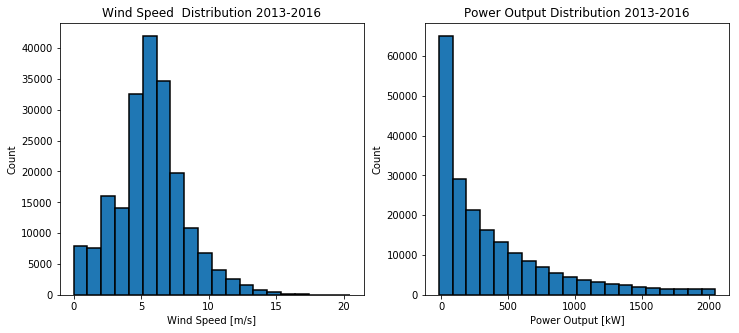

In [12]:
f = plt.figure(figsize=(12,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(df_no_na['Ws_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax1.set_title('Wind Speed  Distribution 2013-2016')
ax1.set_xlabel('Wind Speed [m/s]')
ax1.set_ylabel('Count')
ax2.hist(df_no_na['P_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax2.set_title('Power Output Distribution 2013-2016')
ax2.set_xlabel('Power Output [kW]')
ax2.set_ylabel('Count')

plt.show()

In [13]:
df_clean = df_no_na[df_no_na['Ws_avg']>3]
df_clean = df_clean[df_clean['Ws_avg'] < 25]
df_clean = df_clean[df_clean['Ba_avg'] < 5]
df_clean = df_clean[df_clean['Ba_avg'] > -5]
df_clean.shape[0]

159329

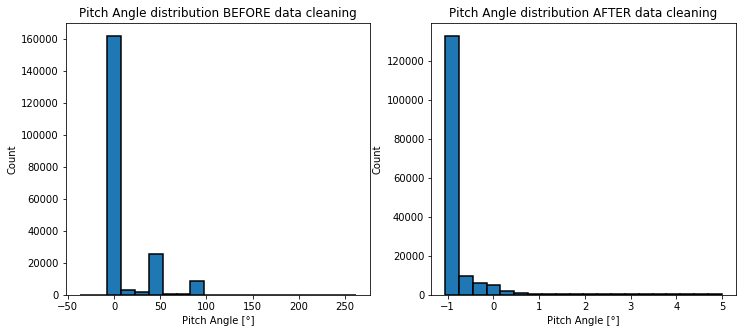

In [14]:
f = plt.figure(figsize=(12,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(df_no_na['Ba_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax1.set_title('Pitch Angle distribution BEFORE data cleaning')
ax1.set_xlabel('Pitch Angle [°]')
ax1.set_ylabel('Count')
ax2.hist(df_clean['Ba_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax2.set_title('Pitch Angle distribution AFTER data cleaning')
ax2.set_xlabel('Pitch Angle [°]')
ax2.set_ylabel('Count')

plt.show()

# PART III: POWER OUTPUT CALCULATION

In [15]:
df_clean['E_avg'] = df_clean['P_avg'] / 6000 # from kW to MWh
df_energy = pd.DataFrame(df_clean.groupby(['Year', 'Month'])['E_avg'].apply(lambda x : x.sum()))
df_energy.reset_index(inplace=True)

In [16]:
df_energy_boxplot = df_energy[df_energy.E_avg > 10]

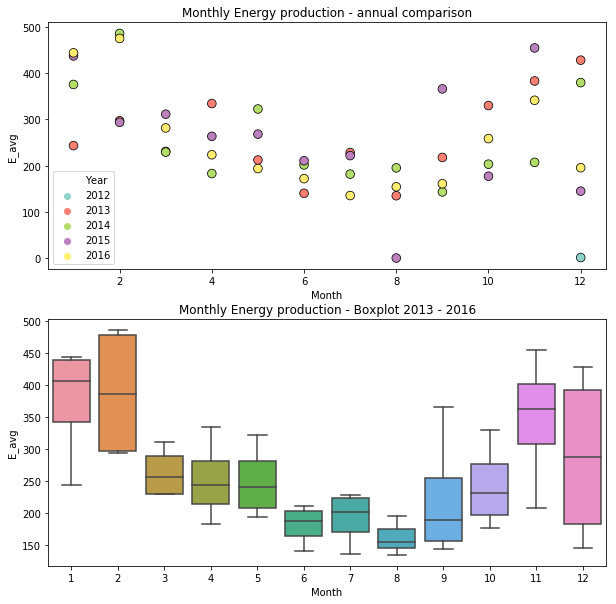

In [25]:
f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

ax1.set_title('Monthly Energy production - annual comparison')
ax1.set_xlabel('Month')
ax1.set_ylabel('Energy production [MWh]')

ax2.set_title('Monthly Energy production - Boxplot 2013 - 2016')
ax2.set_xlabel('Month')
ax2.set_ylabel('Energy production [MWh]')

sns.scatterplot(x="Month", y="E_avg", hue = 'Year', data=df_energy, s = 75, ax = ax1, palette = "Set3", edgecolor = 'black',legend='full')
sns.catplot(x="Month", y="E_avg", kind="box", data=df_energy_boxplot, ax = ax2)
plt.close(2)

## PART IV: CAPACITY FACTORY ESTIMATION

In [19]:
P_nom = 2050 # kW | nominal power
df_clean['Cf_avg'] = df_clean['P_avg'] / P_nom # from kW to CF
df_cf = pd.DataFrame(df_clean.groupby(['Year', 'Month'])['Cf_avg'].apply(lambda x : x.mean()))
df_cf.reset_index(inplace=True)

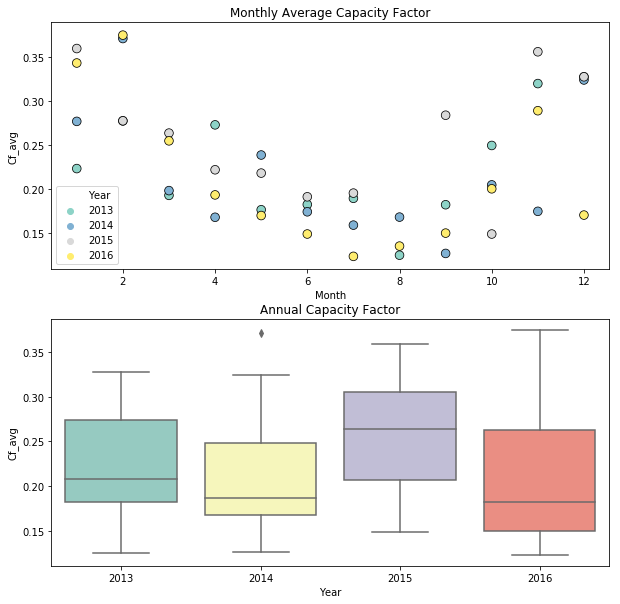

In [26]:
df_cf_boxplot = df_cf[(df_cf.Cf_avg > 0.05) & (df_cf.Cf_avg < 0.5)]

f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

ax1.set_title('Monthly Average Capacity Factor')
ax1.set_xlabel('Month')
ax1.set_ylabel('Capacity Factor')

ax2.set_title('Annual Capacity Factor')
ax2.set_xlabel('Month')
ax2.set_ylabel('Capacity Factor')

sns.scatterplot(x="Month", y="Cf_avg", hue = 'Year', data=df_cf_boxplot, s = 75, ax = ax1, palette = "Set3", edgecolor = 'black')
sns.catplot(x="Year", y="Cf_avg", kind = 'box', data=df_cf_boxplot, ax = ax2, palette = "Set3")
plt.close(2)